In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
NUM_FOLDS = 10
NUM_SEEDS = 10

# Loading

In [3]:
raw_df = pd.read_csv('123_results.csv')
raw_test_df = pd.read_csv('test_results.csv')
masks = pd.read_csv('masks.csv')

In [4]:
# collect columns
columns = list(raw_df.columns)
columns = \
    columns[:10] + \
    columns[11:13] + \
    columns[15:] + \
    ['pre_' + i for i in columns[13:15]] + \
    ['post_' + i for i in columns[13:15]] + \
    ['pre_final_accuracy'] + \
    ['post_final_accuracy'] + \
    ['t1_final_accuracy'] + \
    ['t2_final_accuracy'] + \
    ['final_accuracy'] + \
    ['t1_auc'] + \
    ['t2_auc'] + \
    ['auc'] + \
    ['unweighted_post_final_accuracy'] + \
    ['one_two_confusion'] + \
    ['three_confusion']  + \
    ['final_one_two_confusion'] + \
    ['final_three_confusion']

# collect rows
rows = list()
for i in range(len(raw_df)):
    if not i % 2:
        assert(raw_df.loc[i]['stage'] == 'post')
        post_row = list(raw_df.loc[i])
    else:
        assert(raw_df.loc[i]['stage'] == 'pre')
        pre_row = list(raw_df.loc[i])
        for j in range(10):
            assert(post_row[j] == pre_row[j])
        t1_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['1', '2']))]['count'].sum()
        t2_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['3']))]['count'].sum()
        p = np.array([np.reshape([int(j) for j in i.split(':')], (3, 3)) for i in post_row[15].split('_')])
        one_two_confusions = (p[:, 1, 0] + p[:, 0, 1]) / np.sum(p[:, :, 0] + p[:, :, 1], axis=1)
        three_confusions = (p[:, 2, 0] + p[:, 2, 1]) / np.sum(p[:, :, 0] + p[:, :, 1], axis=1)
        assert(np.count_nonzero(np.sum(p[:, :, 0] + p[:, :, 1], axis=1)) == p.shape[0])
        row = \
            pre_row[:10] + \
            [np.array([float(i) for i in post_row[11].split('_')])] + \
            [np.array([float(i) for i in post_row[12].split('_')])] + \
            [p] + \
            [float(i) for i in pre_row[13:15]] + \
            [float(i) for i in post_row[13:15]] + \
            [float((pre_row[13] * t1_size + pre_row[14] * t2_size) / (t1_size + t2_size))] + \
            [float((post_row[13] * t1_size + post_row[14] * t2_size) / (t1_size + t2_size))] + \
            [float((pre_row[13] + post_row[13]) / 2)] + \
            [float((pre_row[14] + post_row[14]) / 2)] + \
            [float(((pre_row[13] + post_row[13]) * t1_size / 2 + (pre_row[14] + post_row[14]) * t2_size / 2) / (t1_size + t2_size))] + \
            [np.sum([float(i) for i in post_row[11].split('_')])] + \
            [np.sum([float(i) for i in post_row[12].split('_')])] + \
            [(np.sum([float(i) for i in post_row[11].split('_')]) * t1_size + np.sum([float(i) for i in post_row[12].split('_')]) * t2_size) / (t1_size + t2_size)] + \
            [float((post_row[13] + post_row[14]) / 2)] + \
            [one_two_confusions] + \
            [three_confusions] + \
            [one_two_confusions[-1]] + \
            [three_confusions[-1]]
        assert(len(row) == len(columns))
        rows.append(row)

# build new data frame
data = dict()
for i in range(len(columns)):
    data[columns[i]] = list()
    for j in range(len(rows)):
        data[columns[i]].append(rows[j][i])
df = pd.DataFrame(data=data)

In [5]:
df.head()

,seed,test_fold,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,...,t2_final_accuracy,final_accuracy,t1_auc,t2_auc,auc,unweighted_post_final_accuracy,one_two_confusion,three_confusion,final_one_two_confusion,final_three_confusion
0,0,0,100,adam,0.1,None,0.75,0.99999,None,50,...,0.0,0.31618,46.8922,0.0,31.61803,0.234461,"[0.5310778914240756, 0.5310778914240756, 0.531...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531078,0.0
1,0,0,100,adam,0.1,None,0.75,0.999,None,50,...,0.0,0.31618,46.8922,0.0,31.61803,0.234461,"[0.5310778914240756, 0.5310778914240756, 0.531...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531078,0.0
2,0,0,100,adam,0.1,None,0.75,0.9,None,50,...,0.0,0.31618,46.8922,0.0,31.61803,0.234461,"[0.5310778914240756, 0.5310778914240756, 0.531...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531078,0.0
3,0,0,100,adam,0.1,None,0.9,0.99999,None,50,...,0.0,0.31618,46.8922,0.0,31.61803,0.234461,"[0.5310778914240756, 0.5310778914240756, 0.531...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531078,0.0
4,0,0,100,adam,0.1,None,0.9,0.999,None,50,...,0.0,0.31618,46.8922,0.0,31.61803,0.234461,"[0.5310778914240756, 0.5310778914240756, 0.531...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531078,0.0


In [11]:
x = np.array(df.loc[0]['predictions'])

# Filtering

In [14]:
x[90, ...]

array([[  0,   0,   0],
       [675, 596, 614],
       [  0,   0,   0]])

In [42]:
COLUMN = 'unweighted_post_final_accuracy'  # 'final_accuracy' 'auc' 'pre_final_accuracy' post_final_accuracy' 'unweighted_post_final_accuracy' 'final_one_two_confusion' 'final_three_confusion'
MAXIMIZE = True

In [43]:
# adf = df.drop(columns=['test_fold'])
# grouped_columns, agg_columns = list(adf.columns[:9]), list(adf.columns[9:])
adf = df.drop(columns=['seed', 'test_fold'])
grouped_columns, agg_columns = list(adf.columns[:8]), list(adf.columns[8:])
grouped = adf.groupby(grouped_columns)
data = {k: list() for k in grouped_columns}
for column in agg_columns:
    data[column + '_mean'] = list()
    data[column + '_std'] = list()
    data[column + '_min'] = list()
    data[column + '_max'] = list()
for k, v in grouped:
    i = 0
    for v2 in k:
        data[adf.columns[i]].append(v2)
        i += 1
    while i < len(adf.columns):
        data[adf.columns[i] + '_mean'].append(np.nanmean(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_std'].append(np.nanstd(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_min'].append(np.nanmin(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_max'].append(np.nanmax(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        i += 1
adf = pd.DataFrame(data=data)

In [44]:
fdf = pd.DataFrame(columns=adf.columns)
# for seed in np.unique(adf['seed'].values):
#     for epoch in np.unique(adf['epochs'].values):
#         adam_df = adf[(adf['optimizer'] == 'adam') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
#         rms_df = adf[(adf['optimizer'] == 'rms') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
#         sgd_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.0'])]
#         sgdmom_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.75', '0.9', '0.999'])]
for epoch in np.unique(adf['epochs'].values):
    adam_df = adf[(adf['optimizer'] == 'adam') & (adf['epochs'] == epoch)]
    rms_df = adf[(adf['optimizer'] == 'rms') & (adf['epochs'] == epoch)]
    sgd_df = adf[(adf['optimizer'] == 'sgd') & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.0'])]
    sgdmom_df = adf[(adf['optimizer'] == 'sgd') & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.75', '0.9', '0.999'])]
    if MAXIMIZE:
        fdf = fdf.append(adam_df.loc[adam_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(rms_df.loc[rms_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(sgd_df.loc[sgd_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(sgdmom_df.loc[sgdmom_df[COLUMN + '_mean'].idxmax()])
    else:
        fdf = fdf.append(adam_df.loc[adam_df[COLUMN + '_mean'].idxmin()])
        fdf = fdf.append(rms_df.loc[rms_df[COLUMN + '_mean'].idxmin()])
        fdf = fdf.append(sgd_df.loc[sgd_df[COLUMN + '_mean'].idxmin()])
        fdf = fdf.append(sgdmom_df.loc[sgdmom_df[COLUMN + '_mean'].idxmin()])

In [45]:
fdf.head()

,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,t1_accuracies_mean,t1_accuracies_std,...,three_confusion_min,three_confusion_max,final_one_two_confusion_mean,final_one_two_confusion_std,final_one_two_confusion_min,final_one_two_confusion_max,final_three_confusion_mean,final_three_confusion_std,final_three_confusion_min,final_three_confusion_max
28,100,adam,0.01000,None,0.75,0.999,None,50,"[0.9930633599999998, 0.9929366300000001, 0.994...","[0.004130159351695767, 0.004968060045238988, 0...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000323,0.001350,0.000000,0.008661,0.903357,0.235382,0.000000,1.0000
54,100,rms,0.01000,None,None,None,0.9,50,"[0.9942602199999999, 0.9947008200000004, 0.995...","[0.002300596164388707, 0.0021098917810162742, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.981975,0.017699,0.908733,1.0000
60,100,sgd,0.00001,0.0,None,None,None,50,"[0.46421286000000017, 0.4815828900000003, 0.49...","[0.09336315099920525, 0.08714248838722648, 0.0...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4846577498033045, 0.40504334121355395, 0.33...",0.028732,0.017305,0.003147,0.069237,0.549072,0.177592,0.262411,0.8684
62,100,sgd,0.00001,0.9,None,None,None,50,"[0.5922206499999999, 0.69670962, 0.78046541999...","[0.0861524861702058, 0.09127436274198578, 0.07...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06535433070866142, 0.01653543307086614, 0.0...",0.000000,0.000000,0.000000,0.000000,0.953188,0.057952,0.780315,1.0000


# Plotting

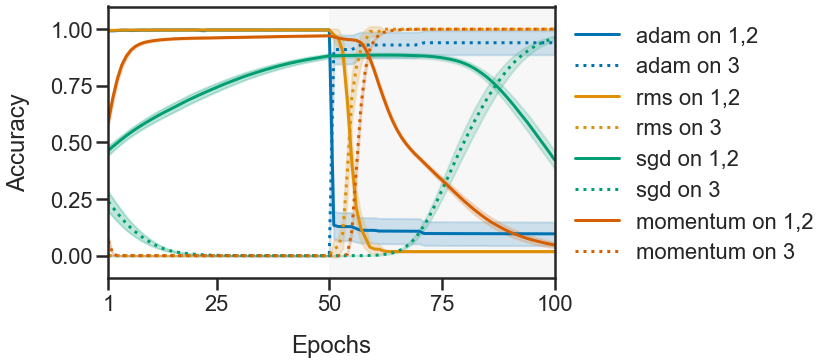

In [49]:
sns.set()
sns.set_style('ticks')
sns.set_context('poster')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
palette = sns.color_palette('colorblind', 4)
labels = list()
ax.set_yticks(list(np.linspace(0, 1.0, 5, endpoint=True)))
ax.set_ylabel('Accuracy', labelpad=20)
ax.set_xticks([1] + list(np.linspace(0, 100, 5, endpoint=True)))
ax.set_xlabel('Epochs', labelpad=20)
ax.set_ylim(- 0.1, 1.1)
ax.set_xlim(1, 100)
labels.clear()
for k, (_, row) in enumerate(fdf.iterrows()):
    if row['optimizer'] == 'sgd':
        label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
    else:
        label = row['optimizer']
    labels.append(label + ' on 1,2')
    labels.append(label + ' on 3')
    x = np.arange(len(row['t1_accuracies_mean'])) + 1
    ax.add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
    ax.plot(
        x,
        row['t1_accuracies_mean'],
        linestyle='-',
        color=palette[k])
    ax.fill_between(
        x,
        row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        color=palette[k],
        alpha=0.25)
    ax.plot(
        x,
        row['t2_accuracies_mean'],
        linestyle=':',
        color=palette[k])
    ax.fill_between(
        x,
        row['t2_accuracies_mean'] - row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        row['t2_accuracies_mean'] + row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        color=palette[k],
        alpha=0.25)
legend = ax.legend(ax.get_lines(), labels, loc=(1.025, 0.025), ncol=1, frameon=False)
fig.savefig('{}_accuracies.pdf'.format(COLUMN), bbox_extra_artists=(legend,), bbox_inches='tight')

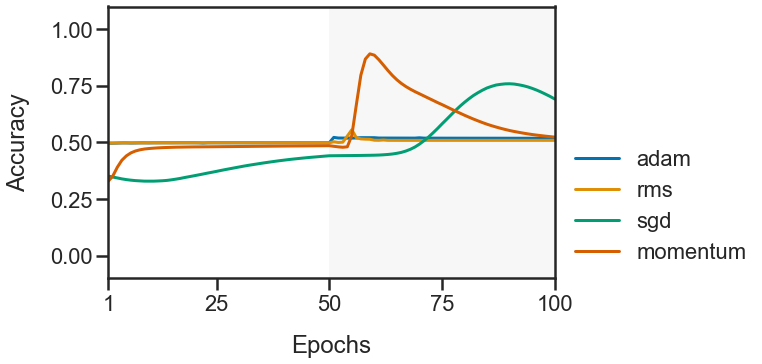

In [51]:
sns.set()
sns.set_style('ticks')
sns.set_context('poster')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
palette = sns.color_palette('colorblind', 4)
labels = list()
ax.set_yticks(list(np.linspace(0, 1.0, 5, endpoint=True)))
ax.set_ylabel('Accuracy', labelpad=20)
ax.set_xticks([1] + list(np.linspace(0, 100, 5, endpoint=True)))
ax.set_xlabel('Epochs', labelpad=20)
ax.set_ylim(- 0.1, 1.1)
ax.set_xlim(1, 100)
labels.clear()
for k, (_, row) in enumerate(fdf.iterrows()):
    if row['optimizer'] == 'sgd':
        label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
    else:
        label = row['optimizer']
    labels.append(label)
    x = np.arange(len(row['t1_accuracies_mean'])) + 1
    ax.add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
    ax.plot(
        x,
        (row['t1_accuracies_mean'] + row['t2_accuracies_mean']) / 2,
        linestyle='-',
        color=palette[k])
#     ax.fill_between(
#         x,
#         row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
#         row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
#         color=palette[k],
#         alpha=0.25)
legend = ax.legend(ax.get_lines(), labels, loc=(1.025, 0.025), ncol=1, frameon=False)
fig.savefig('{}_sum_accuracies.pdf'.format(COLUMN), bbox_extra_artists=(legend,), bbox_inches='tight')

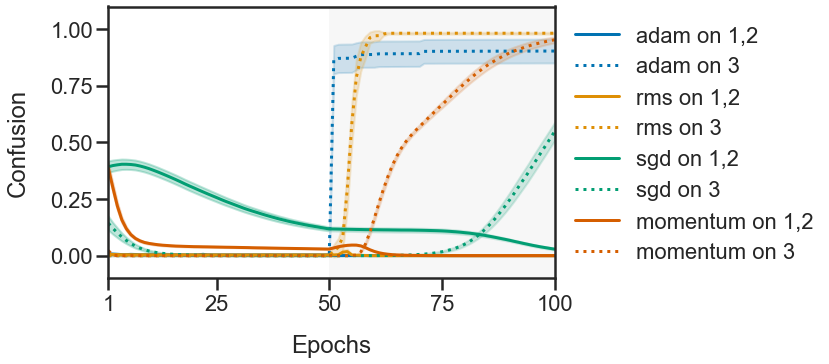

In [47]:
sns.set()
sns.set_style('ticks')
sns.set_context('poster')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
palette = sns.color_palette('colorblind', 4)
labels = list()
ax.set_yticks(list(np.linspace(0, 1.0, 5, endpoint=True)))
ax.set_ylabel('Confusion', labelpad=20)
ax.set_xticks([1] + list(np.linspace(0, 100, 5, endpoint=True)))
ax.set_xlabel('Epochs', labelpad=20)
ax.set_ylim(- 0.1, 1.1)
ax.set_xlim(1, 100)
labels.clear()
for k, (_, row) in enumerate(fdf.iterrows()):
    if row['optimizer'] == 'sgd':
        label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
    else:
        label = row['optimizer']
    labels.append(label + ' on 1,2')
    labels.append(label + ' on 3')
    x = np.arange(len(row['one_two_confusion_mean'])) + 1
    ax.add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
    ax.plot(
        x,
        row['one_two_confusion_mean'],
        linestyle='-',
        color=palette[k])
    ax.fill_between(
        x,
        row['one_two_confusion_mean'] - row['one_two_confusion_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        row['one_two_confusion_mean'] + row['one_two_confusion_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        color=palette[k],
        alpha=0.25)
    ax.plot(
        x,
        row['three_confusion_mean'],
        linestyle=':',
        color=palette[k])
    ax.fill_between(
        x,
        row['three_confusion_mean'] - row['three_confusion_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        row['three_confusion_mean'] + row['three_confusion_std'] / np.sqrt(NUM_FOLDS + NUM_SEEDS),
        color=palette[k],
        alpha=0.25)
legend = ax.legend(ax.get_lines(), labels, loc=(1.025, 0.025), ncol=1, frameon=False)
fig.savefig('{}_confusion.pdf'.format(COLUMN), bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
# sns.set()
# sns.set_style('ticks')
# sns.set_context('poster')
# fig, axmat = plt.subplots(len(np.unique(fdf['seed'].values)), len(np.unique(fdf['epochs'].values)), figsize=(8 * len(np.unique(fdf['epochs'].values)), 5 * len(np.unique(fdf['seed'].values))))
# for i, seed in enumerate(np.unique(fdf['seed'].values)):
#     sfdf = fdf[fdf['seed'] == seed]
#     palette = sns.color_palette('colorblind', 4)
#     labels = list()
#     for j, epoch in enumerate(np.unique(sfdf['epochs'].values)):
#         if j == 0:
#             axmat[i, j].set_yticks(list(np.linspace(0, 1.0, 5, endpoint=True)))
#             axmat[i, j].set_ylabel('Accuracy', labelpad=20)
#         else:
#             axmat[i, j].set_yticks([])
#         if i == 2:
#             if j == 0:
#                 axmat[i, j].set_xticks([1, 3, 5, 7, 10])
#             else:
#                 axmat[i, j].set_xticks([1] + list(np.linspace(0, epoch * 2, 5, endpoint=True)))
#             axmat[i, j].set_xlabel('Epochs', labelpad=20)
#         else:
#             axmat[i, j].set_xticks([])
#         axmat[i, j].set_ylim(- 0.1, 1.1)
#         axmat[i, j].set_xlim(1, epoch * 2)
#         labels.clear()
#         for k, (_, row) in enumerate(sfdf[sfdf['epochs'] == epoch].iterrows()):
#             if row['optimizer'] == 'sgd':
#                 label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
#             else:
#                 label = row['optimizer']
#             labels.append(label + ' on 1,2')
#             labels.append(label + ' on 3')
#             x = np.arange(len(row['t1_accuracies_mean'])) + 1
#             axmat[i, j].add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
#             axmat[i, j].plot(
#                 x,
#                 row['t1_accuracies_mean'],
#                 linestyle='-',
#                 color=palette[k])
#             axmat[i, j].fill_between(
#                 x,
#                 row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                 row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                 color=palette[k],
#                 alpha=0.25)
#             axmat[i, j].plot(
#                 x,
#                 row['t2_accuracies_mean'],
#                 linestyle=':',
#                 color=palette[k])
#             axmat[i, j].fill_between(
#                 x,
#                 row['t2_accuracies_mean'] - row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                 row['t2_accuracies_mean'] + row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                 color=palette[k],
#                 alpha=0.25)
# legend = fig.legend(axmat[0, 0].get_lines(), labels, loc=(0.9, 0.685), ncol=1, frameon=False)
# fig.subplots_adjust(wspace=0.125, hspace=0.175)
# fig.savefig('{}.pdf'.format(COLUMN), bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
# with PdfPages('{}.pdf'.format(COLUMN)) as pdf:
#     sns.set()
#     sns.set_style('ticks')
#     sns.set_context('talk')
#     for seed in np.unique(fdf['seed'].values):
#         sfdf = fdf[fdf['seed'] == seed]
#         fig, axarr = plt.subplots(len(np.unique(sfdf['epochs'].values)), 1, figsize=(15, 20))
#         palette = sns.color_palette('colorblind', 4)
#         labels = list()
#         axarr[0].set_title('SEED = {}'.format(seed), pad=20)
#         for i, epoch in enumerate(np.unique(sfdf['epochs'].values)):
#             axarr[i].set_ylabel('Accuracy', labelpad=20)
#             if i == 4: axarr[i].set_xlabel('Epochs', labelpad=20)
#             axarr[i].set_xticks(np.linspace(0, epoch * 2, 5, endpoint=True))
#             axarr[i].set_xlim(1, epoch * 2)
#             axarr[i].set_ylim(- 0.1, 1.1)
#             labels.clear()
#             for j, (_, row) in enumerate(sfdf[sfdf['epochs'] == epoch].iterrows()):
#                 if row['optimizer'] == 'sgd':
#                     label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
#                 else:
#                     label = row['optimizer']
#                 labels.append(label + ' on 1,2')
#                 labels.append(label + ' on 3')
#                 x = np.arange(len(row['t1_accuracies_mean'])) + 1
#                 axarr[i].add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
#                 axarr[i].plot(x,
#                               row['t1_accuracies_mean'],
#                               linestyle='-',
#                               color=palette[j])
#                 axarr[i].fill_between(x,
# #                               row['t1_accuracies_min'],
# #                               row['t1_accuracies_max'],
#                               row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               color=palette[j],
#                               alpha=0.25)
#                 axarr[i].plot(x,
#                               row['t2_accuracies_mean'],
#                               linestyle=':',
#                               color=palette[j])
#                 axarr[i].fill_between(x,
# #                               row['t2_accuracies_min'],
# #                               row['t2_accuracies_max'],
#                               row['t2_accuracies_mean'] - row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               row['t2_accuracies_mean'] + row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               color=palette[j],
#                               alpha=0.25)
#         legend = fig.legend(axarr[0].get_lines(), labels, loc=(0.81, 0.7875), ncol=1, frameon=False)
#         fig.subplots_adjust(right=0.8)
#         pdf.savefig(fig, bbox_extra_artists=(legend,), bbox_inches='tight')